# Deep learning MLLB
Stiene Vanderbeke

Load packages

In [1]:
import os, random
import numpy as np # linear algebra
from scipy.io import loadmat
import imageio
import cv2
import tensorflow as tf
from tensorflow.keras.utils  import load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from tqdm.notebook import tqdm
from skimage import exposure

from skimage import exposure


import matplotlib.pylab as plt
%matplotlib inline

from google.colab import drive

## 1. Load the dataset

In [ ]:
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Colab Notebooks/Deep Learning project"

data = loadmat('./data/Xray_data.mat')
images, labels = data['images'], data['labels']


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Deep Learning project


In [ ]:
print(images.shape)
print(labels.shape)

(247, 512, 512)
(247, 512, 512, 5)


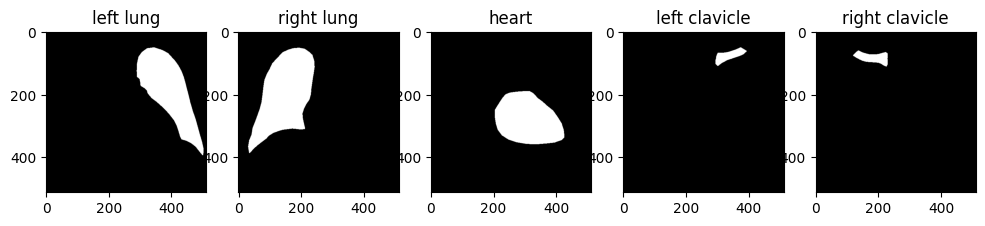

In [ ]:
N = 230  # Change this number to visualize another labelmap
plt.figure(figsize=(12,5))
titles = ['left lung', 'right lung', 'heart', 'left clavicle', 'right clavicle']
for i in range(labels.shape[-1]):
  plt.subplot(1,labels.shape[-1],i+1)
  plt.imshow(labels[N,:,:,i], 'gray')
  plt.title(titles[i])

Create a function to show the images with their class overlay. Another function is also created to visualize the predicted classes after training.

In [ ]:
# Plotting function
def plot_image_and_label(image,label,values_255=True):
  '''
  Function for plotting images and labels
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  labelmap = np.zeros(image.shape)
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(14,8))
  plt.subplot(1,3,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,3,2)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,3,3)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

# Plotting function
def plot_image_and_pred_label(image,pred_label,label,values_255=True):
  '''
  Function for plotting images and labels (predicted and GT)
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  pred_labelmap = np.zeros(image.shape)
  labelmap = np.zeros(image.shape)
  for i in range(pred_label.shape[-1]):
    pred_labelmap[pred_label[:,:,i]==1] = i+1
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(16,12))
  plt.subplot(1,5,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,5,2)
  plt.imshow(pred_labelmap, 'gray')
  plt.title("Predicted mask")
  plt.subplot(1,5,3)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,5,4)
  plt.imshow(label2rgb(label=pred_labelmap, image=image_plot, bg_label=0))
  plt.title("Image + Predicted Mask")
  plt.subplot(1,5,5)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

Show an image with their corresponding labels.

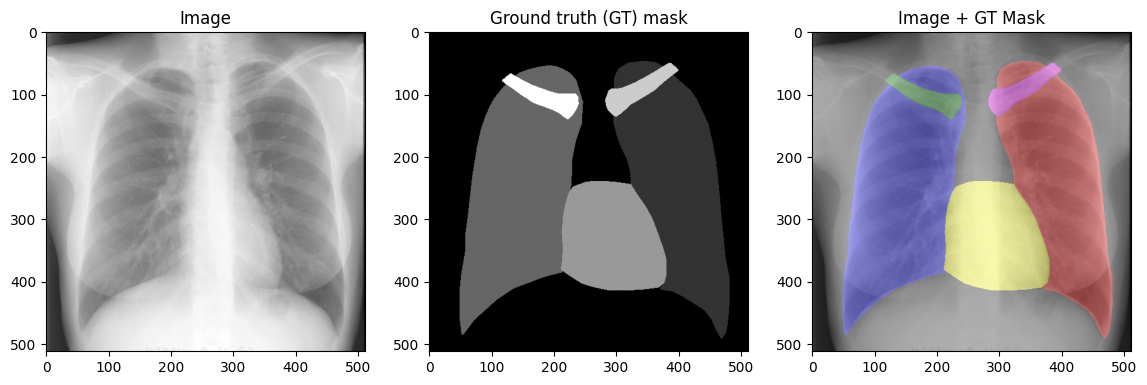

In [ ]:
N = 0  # Change this number to visualize another image-mask set
img = images[N]
mask = labels[N]
plot_image_and_label(img,mask)

## 2. Data preparation and analysis

### 2.1. CLAHE and normalization

Apply contrast limited adaptive histogram equalization (CLAHE) to the images. By applying this equalization, we are able to perform a better segmentation of the different structures present in the image

In [ ]:
def preprocess_img(img):
  max_value = np.max(img)
  img = exposure.equalize_adapthist(img)
  img = cv2.normalize(img, None, 0, max_value, cv2.NORM_MINMAX).astype(np.uint8)

  return img

In [ ]:
X = np.zeros(images.shape)
y = labels.astype(np.float32)
for i, (img, lbl) in enumerate(tqdm(zip(images,labels), total=len(images))):
  img_preprocessed =  preprocess_img(img)
  X[i] = img_preprocessed

  0%|          | 0/247 [00:00<?, ?it/s]

Normalize the images to zero-mean and unit variance.

In [ ]:
def normalize_img(img, epsilon=1e-10):
  img_norm = (img - np.mean(img)) / (np.std(img) + epsilon)
  return img_norm

In [ ]:
X_norm = np.empty_like(X, dtype=np.float32)
for i in range(X.shape[0]):
    X_norm[i] = normalize_img(X[i])

X = X_norm

In [ ]:
print(X.shape, X.dtype)          # (N, H, W) float32
print(np.mean(X[0]), np.std(X[0]))  # ≈ 0.0, ≈ 1.0


(247, 512, 512) float32
0.0 0.99999994


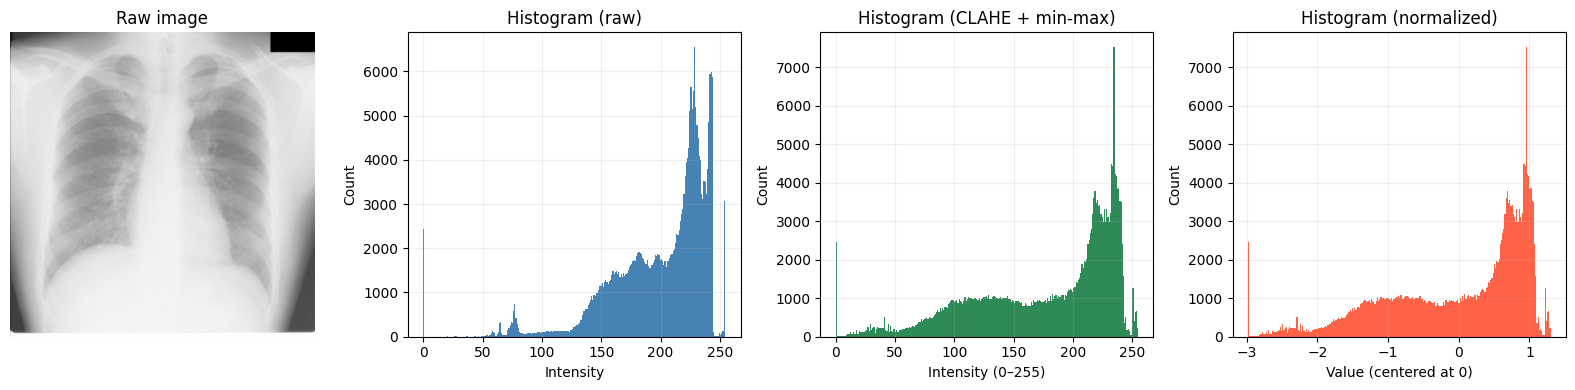

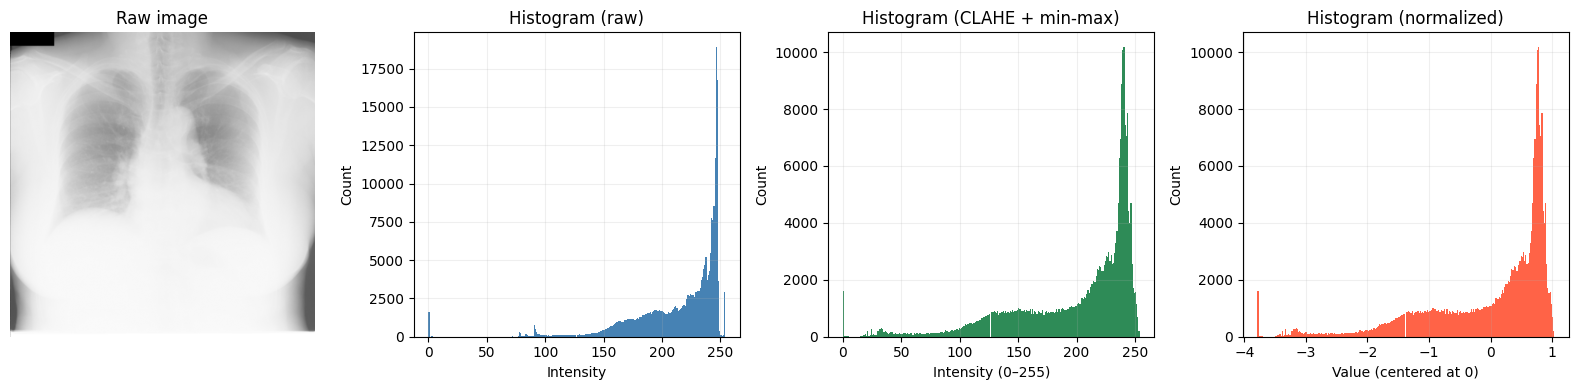

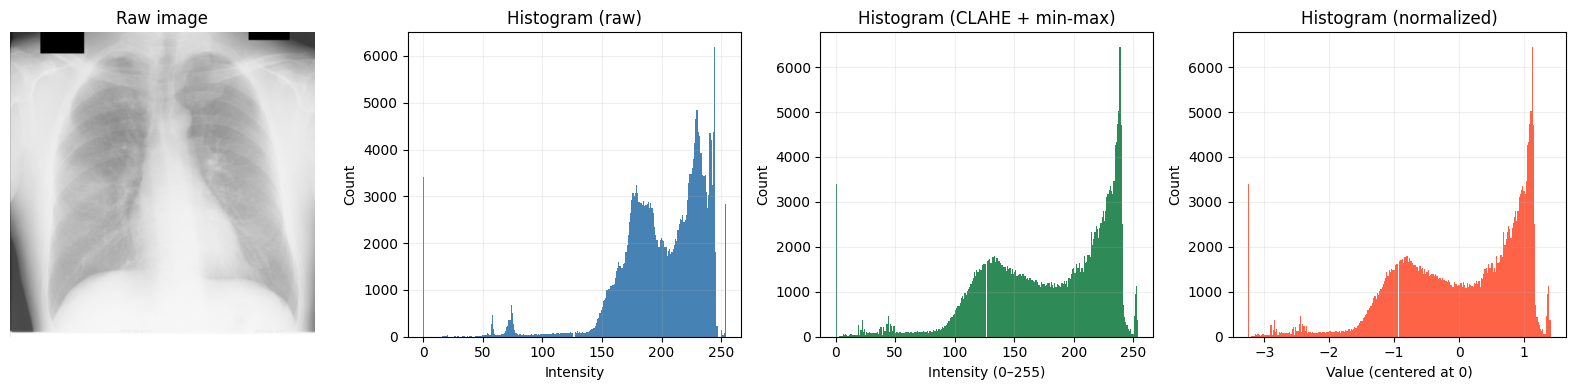

In [ ]:
# Recompute CLAHE+minmax for a few samples (for visualization)
def clahe_minmax_uint8(img):
    max_value = np.max(img)
    img_c = exposure.equalize_adapthist(img)              # float in [0,1]
    img_c = cv2.normalize(img_c, None, 0, max_value, cv2.NORM_MINMAX)
    return img_c.astype(np.uint8)

idxs = np.random.randint(0, len(images), size=3)
for i in idxs:
    raw = images[i]
    clahe_img = clahe_minmax_uint8(raw)
    norm_img = X[i]  # already normalized to zero-mean/unit-variance

    plt.figure(figsize=(16,4))

    # Raw
    plt.subplot(1,4,1)
    plt.imshow(raw, cmap='gray')
    plt.title("Raw image")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.hist(raw.ravel(), bins=256, color='steelblue')
    plt.title("Histogram (raw)")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.2)

    # CLAHE + min-max
    plt.subplot(1,4,3)
    plt.hist(clahe_img.ravel(), bins=256, color='seagreen')
    plt.title("Histogram (CLAHE + min-max)")
    plt.xlabel("Intensity (0–255)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.2)

    # Normalized (zero-mean/unit-variance)
    plt.subplot(1,4,4)
    plt.hist(norm_img.ravel(), bins=256, color='tomato')
    plt.title("Histogram (normalized)")
    plt.xlabel("Value (centered at 0)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()


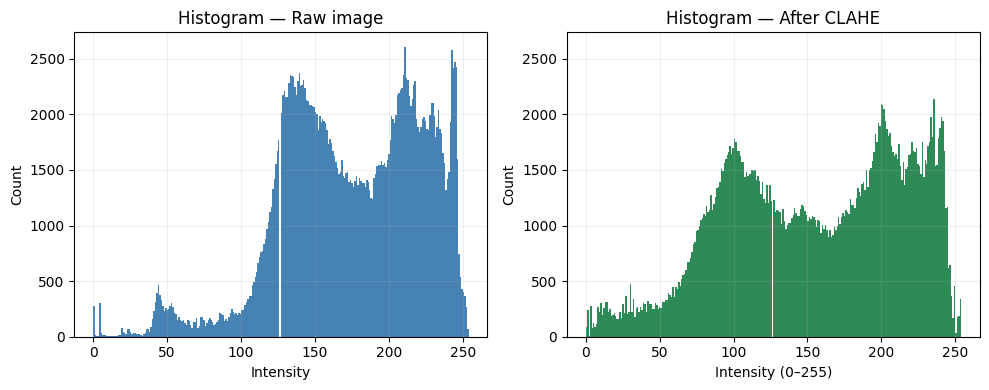

In [ ]:
# Helper: CLAHE + min-max to uint8
def clahe_minmax_uint8(img):
    max_value = np.max(img)
    img_c = exposure.equalize_adapthist(img)              # float in [0,1]
    img_c = cv2.normalize(img_c, None, 0, max_value, cv2.NORM_MINMAX)
    return img_c.astype(np.uint8)

# Use the first image (row 0)
i = 0
raw = images[i]
clahe_img = clahe_minmax_uint8(raw)

# Compute histogram counts (same binning) for consistent comparison
bins = 256
raw_counts, raw_edges = np.histogram(raw.ravel(), bins=bins, range=(raw.min(), raw.max()))
clahe_counts, clahe_edges = np.histogram(clahe_img.ravel(), bins=bins, range=(clahe_img.min(), clahe_img.max()))

# Determine a shared y-axis limit
ymax = max(raw_counts.max(), clahe_counts.max())

# Plot side-by-side with shared y-limit
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(raw.ravel(), bins=bins, color='steelblue')
plt.title("Histogram — Raw image")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.ylim(0, ymax * 1.05)  # shared y-limit
plt.grid(True, alpha=0.2)

plt.subplot(1, 2, 2)
plt.hist(clahe_img.ravel(), bins=bins, color='seagreen')
plt.title("Histogram — After CLAHE")
plt.xlabel("Intensity (0–255)")
plt.ylabel("Count")
plt.ylim(0, ymax * 1.05)  # shared y-limit
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


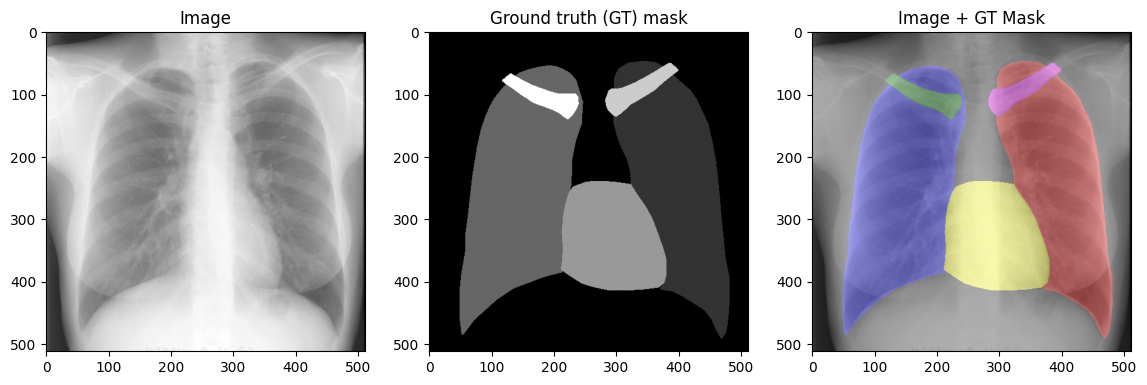

In [ ]:
N = 0  # Change this number to visualize another image-mask set
img = images[N]
mask = labels[N]
plot_image_and_label(img,mask)

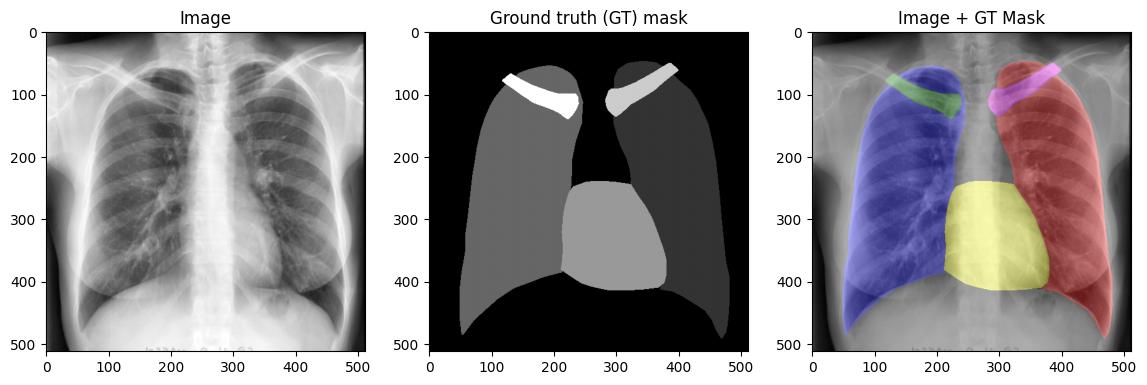

In [ ]:
N = 0  # Change this number to open another set of image-mask
plot_image_and_label(X[N],y[N],values_255=False)

### 2.2. Mask coverage per class

Per-class pixel coverage (mean ± std) across images:
-     left lung:  14.32% ±   2.93%
-    right lung:  17.33% ±   3.02%
-         heart:   9.60% ±   1.46%
- left clavicle:   1.16% ±   0.19%
- right clavicle:   1.15% ±   0.20%


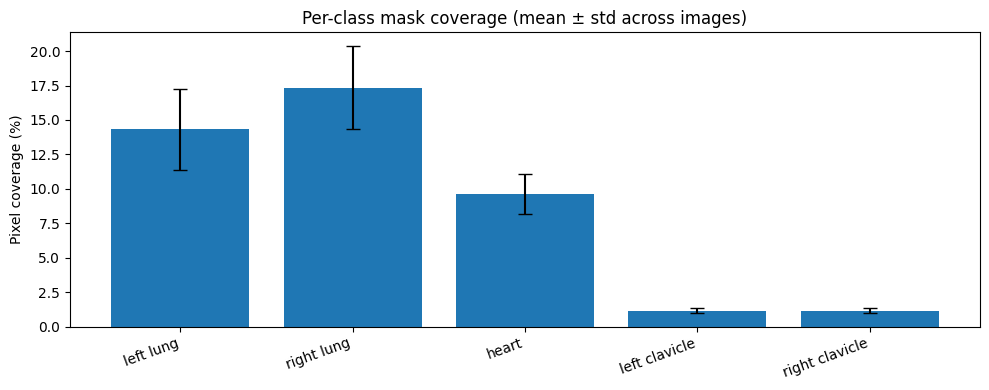

In [ ]:
titles = ['left lung', 'right lung', 'heart', 'left clavicle', 'right clavicle']

def compute_mask_coverage(labels: np.ndarray, class_names=None, threshold=0.5):
    """
    Compute per-class pixel coverage per image and dataset mean/std.

    labels: (N, H, W, C) one-hot / multi-channel binary masks
    threshold: treat pixels > threshold as positive (robust if masks are 0/255 or float)
    returns:
        coverage_per_image: (N, C) fraction of pixels for each class per image
        mean_coverage: (C,) mean fraction across images
        std_coverage: (C,) std fraction across images
    """
    if labels.ndim != 4:
        raise ValueError(f"Expected labels with shape (N,H,W,C), got {labels.shape}")

    N, H, W, C = labels.shape
    total_pixels = H * W

    # Binarize robustly
    bin_masks = (labels > threshold).astype(np.uint8)

    # coverage per image per class: sum over H,W divided by total pixels
    # shape: (N, C)
    coverage_per_image = bin_masks.reshape(N, total_pixels, C).sum(axis=1) / total_pixels

    mean_coverage = coverage_per_image.mean(axis=0)
    std_coverage = coverage_per_image.std(axis=0)

    if class_names is not None and len(class_names) != C:
        raise ValueError(f"class_names has length {len(class_names)} but labels has {C} channels")

    return coverage_per_image, mean_coverage, std_coverage

coverage_per_image, mean_cov, std_cov = compute_mask_coverage(labels, titles, threshold=0)

# Print a nice summary (percentages)
print("Per-class pixel coverage (mean ± std) across images:")
for name, m, s in zip(titles, mean_cov, std_cov):
    print(f"- {name:>13s}: {100*m:6.2f}% ± {100*s:6.2f}%")

# --- Plot: bar chart with error bars (mean ± std) ---
x = np.arange(len(titles))
plt.figure(figsize=(10, 4))
plt.bar(x, mean_cov * 100, yerr=std_cov * 100, capsize=5)
plt.xticks(x, titles, rotation=20, ha='right')
plt.ylabel('Pixel coverage (%)')
plt.title('Per-class mask coverage (mean ± std across images)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(197, 512, 512)
(197, 512, 512, 5)
(50, 512, 512)
(50, 512, 512, 5)


In [ ]:
print(X.shape)

(247, 512, 512)


## 3. Build the U-Net model

In [ ]:
# Define the input image size (width, height, channels) and the number of classes
img_w, img_h = X.shape[2], X.shape[1]
img_c = 1         # grayscale
mask_c = y.shape[-1]

### 3.1. Build the encoder

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
      conv = Dropout(dropout_prob)(conv)


    if max_pooling == True:
      next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
      next_layer = conv


    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
input_size=(img_h, img_w, img_c)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model = tf.keras.Model(inputs=inputs, outputs=cblock1)

#Print model's layers
for layer in model.layers:
    print(layer.name)

input_layer
conv2d
conv2d_1
max_pooling2d


## 6.2 Build the decoder

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(filters = n_filters, kernel_size = (3,3), strides = (2,2), padding = 'same')(expansive_input)

    merge = concatenate([up, contractive_input], axis = 3)

    conv = Conv2D(filters = n_filters, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)

    conv = Conv2D(filters = n_filters, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    return conv

In [ ]:
input_size1 = (64, 64, 32)
input_size2 = (128, 128, 32)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

for layer in model1.layers:
    print(layer.name)

input_layer_1
conv2d_transpose
input_layer_2
concatenate
conv2d_2
conv2d_3


## 6.3. Build the U-Net model

In [ ]:
def unet_model(input_size=(512, 512, 1), n_filters=32, n_classes=5):

    inputs = Input(input_size)

    # Contracting Path (decoding)
    cblock1 = conv_block(inputs, n_filters = n_filters, dropout_prob = 0.0, max_pooling = True)

    cblock2 = conv_block(cblock1[0], n_filters = n_filters*2, dropout_prob=0.0, max_pooling = True)
    cblock3 = conv_block(cblock2[0], n_filters = n_filters*4, dropout_prob=0.0, max_pooling = True)
    cblock4 = conv_block(cblock3[0], n_filters = n_filters*8, dropout_prob=0.0, max_pooling = True)
    cblock5 = conv_block(cblock4[0], n_filters = n_filters*16, dropout_prob=0.0, max_pooling = True)

    cblock6 = conv_block(cblock5[0], n_filters = n_filters*32, dropout_prob=0.3, max_pooling = True)

    LSblock = conv_block(cblock6[0], n_filters = n_filters*64, dropout_prob=0.3, max_pooling = False)


    # Expanding Path (decoding)
    ublock6 = upsampling_block(LSblock[0],   cblock6[1], n_filters=n_filters*32)

    ublock5 = upsampling_block(ublock6, cblock5[1], n_filters=n_filters*16)
    ublock4 = upsampling_block(ublock5, cblock4[1], n_filters=n_filters*8)
    ublock3 = upsampling_block(ublock4, cblock3[1], n_filters=n_filters*4)
    ublock2 = upsampling_block(ublock3, cblock2[1], n_filters=n_filters*2)

    ublock1 = upsampling_block(ublock2, cblock1[1], n_filters=n_filters)

    # Final Conv

    conv_final = Conv2D(filters=n_classes, kernel_size=(1,1), activation='sigmoid', padding='same')(ublock1)

    model = tf.keras.Model(inputs=inputs, outputs=conv_final)

    return model

## 6.4. Initialize model and summary

In [ ]:
# Initialize U-Net model. Input size: (img_h, img_w, img_c); Number of filters: 16. Number of output classes: equal to mask_c (# classes)
unet = unet_model((img_h, img_w, img_c), 16, mask_c)

In [ ]:
# Model summary
unet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 256, 256,  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_10[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_12[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[

 Total params: 34,604,181 (132.00 MB)

 Trainable params: 34,604,181 (132.00 MB)

 Non-trainable params: 0 (0.00 B)

Loss function

In [ ]:
# Dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [ ]:
# Adam optimizer
opt = tf.keras.optimizers.Adam()
# BinaryCrossEntropyLoss
loss = tf.keras.losses.BinaryCrossentropy()
# Compile the model
unet.compile(optimizer=opt,
             loss=loss,
             metrics=['accuracy', dice_coef])

Train the model

In [ ]:
epochs =  200
batch_size =  16
es =  tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', verbose=1, patience=10, restore_best_weights=True)
cb = [es]

In [ ]:
model_history = unet.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.25, callbacks = cb, verbose = 1)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - accuracy: 0.7217 - dice_coef: 0.1646 - loss: 0.6222 - val_accuracy: 0.6603 - val_dice_coef: 0.1808 - val_loss: 0.4603
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.5997 - dice_coef: 0.1795 - loss: 0.6313 - val_accuracy: 0.6693 - val_dice_coef: 0.1886 - val_loss: 0.3780
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.6638 - dice_coef: 0.1796 - loss: 0.3555 - val_accuracy: 0.4962 - val_dice_coef: 0.1865 - val_loss: 0.2977
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - accuracy: 0.3858 - dice_coef: 0.1783 - loss: 0.2823 - val_accuracy: 0.2947 - val_dice_coef: 0.1777 - val_loss: 0.2732
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 683ms/step - accuracy: 0.2468 - dice_coef: 0.1844 - loss: 0.2582 - val_accuracy: 0.2577 - val_dice_coef: 0.2153 - val_loss: 0.2490
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.2724 - dice_coef: 0.2172 - loss: 0.2386 - val_accuracy: 0.3548 - val_

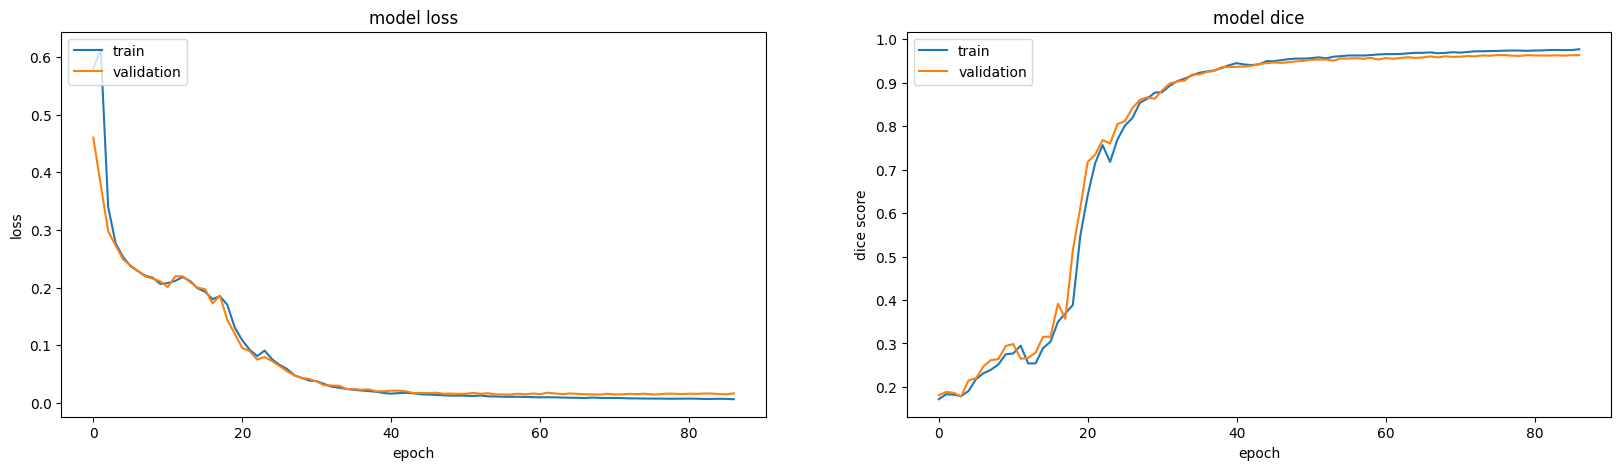

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

Test the model

In [ ]:
y_test_pred =  unet.predict(X_test)

# Apply threshold 0.5
y_test_pred = (y_test_pred > 0.5).astype(np.float32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 29s/step


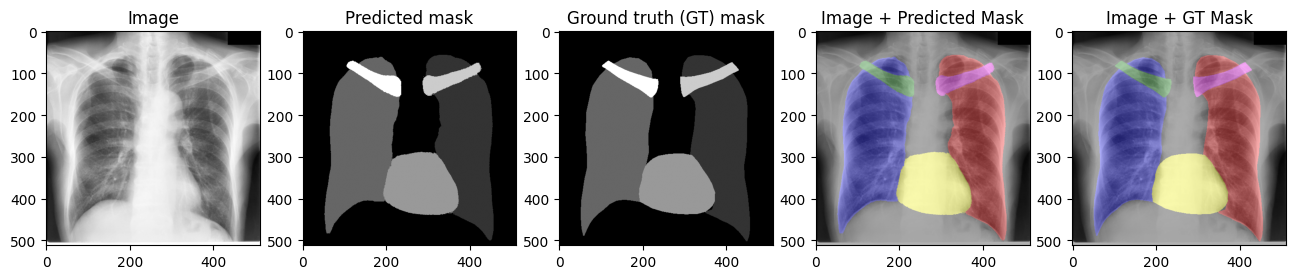

Dice score: 0.9811206459999084


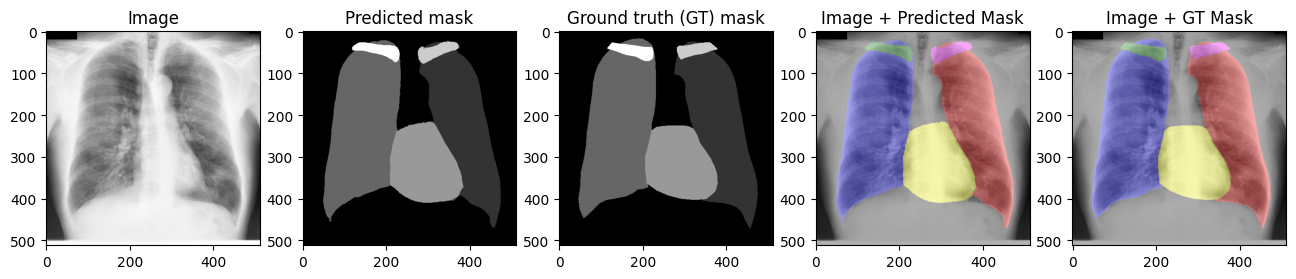

Dice score: 0.9679920673370361


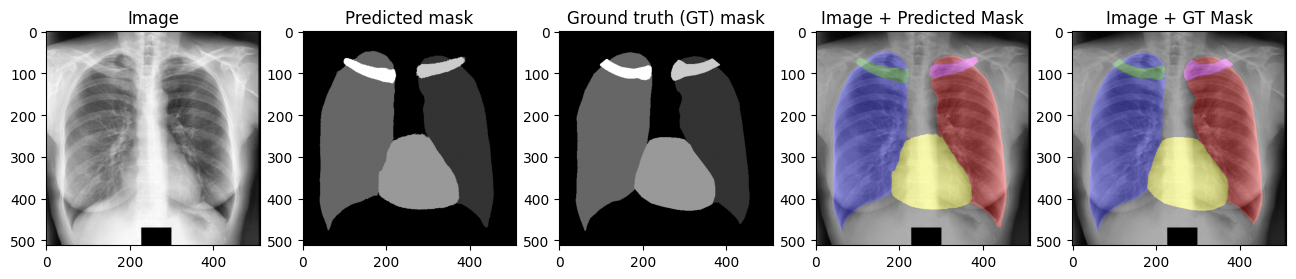

Dice score: 0.9742689728736877


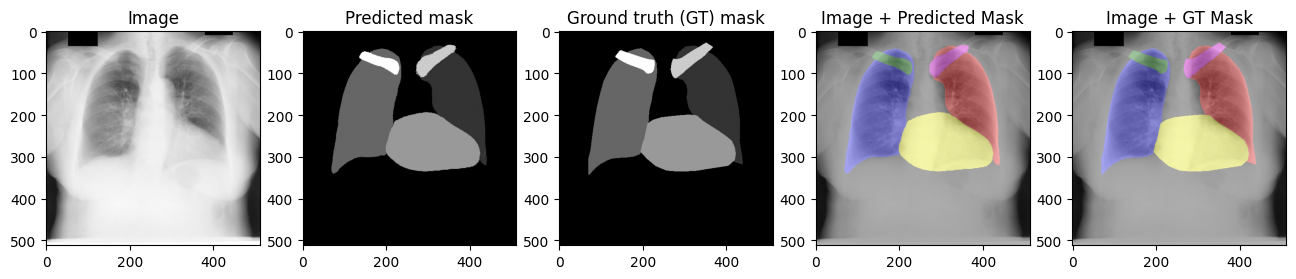

Dice score: 0.9772303104400635


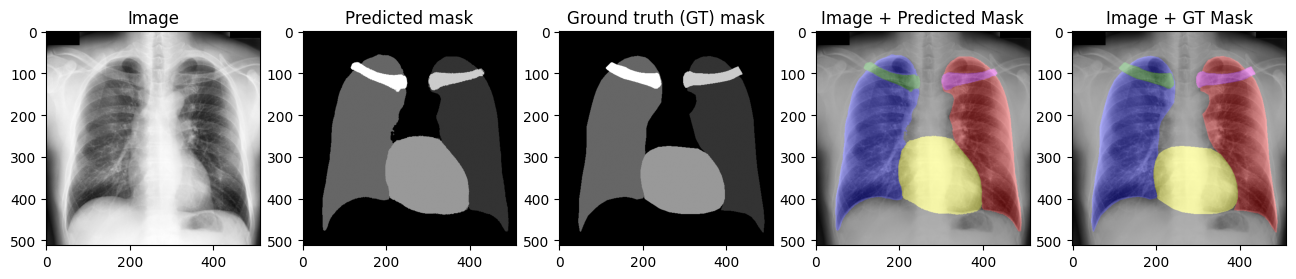

Dice score: 0.9644391536712646


In [ ]:
# Display some examples of predicted mask
indx = np.random.randint(0, len(X_test), 5)

for i in indx:
  plot_image_and_pred_label(X_test[i], y_test_pred[i], y_test[i], values_255=False)
  plt.show()
  print(f"Dice score: {dice_coef(y_test[i], y_test_pred[i])}")

In [ ]:
dice_coef(y_test.astype(np.float32), y_test_pred.astype(np.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9712079763412476>

In [ ]:

test_dice = dice_coef(
    tf.cast(y_test, tf.float32),
    tf.cast(y_test_pred, tf.float32)
).numpy()

print("Dice score on the test set:", test_dice)

Dice score on the test set: 0.971208
